### Change file name

In [2]:
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import sys
import os

# fix problem with local packages
cur_dir = os.getcwd()
sys.path.append(os.path.dirname(cur_dir))

root_dir = '/media/deep/Transcend/sar-rarp-dataset/traindata/video_6.zip/'
seg_dir = 'segmentation/'
rgb_dir = 'rgb/'

# for f_name in glob.glob(root_dir + seg_dir + 'traindata*.png'):
#     img = plt.imread(f_name)
#     new_name = f_name.split('_')[-1]
#     plt.imsave(root_dir + seg_dir + new_name, img)


### View data with seg mask

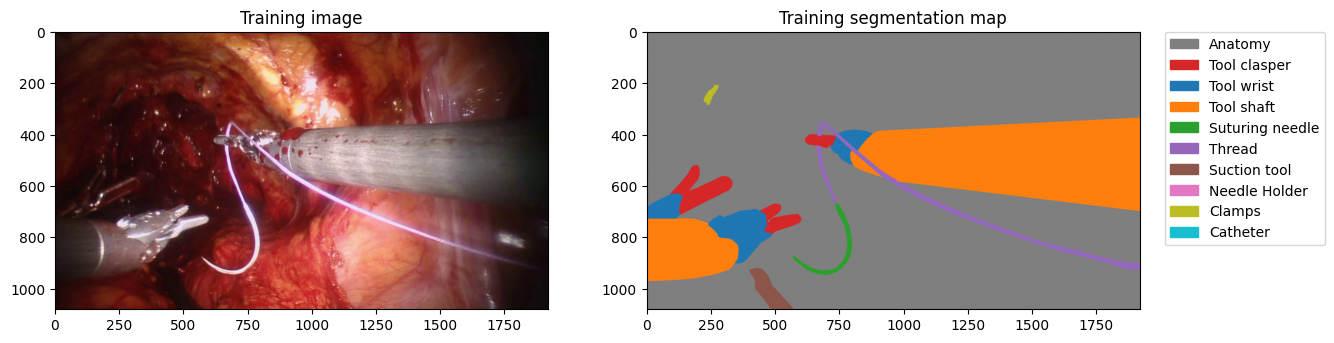

In [6]:
f_name_list = []
for seg_name in glob.glob(root_dir + seg_dir + '*.png'):
    rgb_name = glob.glob(root_dir + rgb_dir + seg_name.split('/')[-1])[0]
    f_name_list.append([rgb_name, seg_name])

colors = ['tab:gray', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
palette_dict = {i: mpl.colors.to_rgb(c) for i, c in enumerate(colors)}
classes = ("Anatomy", "Tool clasper", "Tool wrist", "Tool shaft", "Suturing needle", "Thread", "Suction tool", "Needle Holder", "Clamps", "Catheter")

idx = 15
plt.figure(figsize=(14,20))
plt.subplot(121)
img_rgb = plt.imread(f_name_list[idx][0])
plt.imshow(img_rgb)
plt.title("Training image")

plt.subplot(122)
img_seg = Image.open(f_name_list[idx][1])
img_seg = np.array(img_seg.convert('RGB'), dtype=float)
for i in range(img_seg.shape[0]):
    for j in range(img_seg.shape[1]):
        img_seg[i,j,:] = palette_dict[img_seg[i,j,0]]

patches = [mpatches.Patch(color=colors[i], label=cls) for i, cls in enumerate(classes)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='medium')
plt.imshow(img_seg)
plt.title("Training segmentation map")
plt.show()


### View training

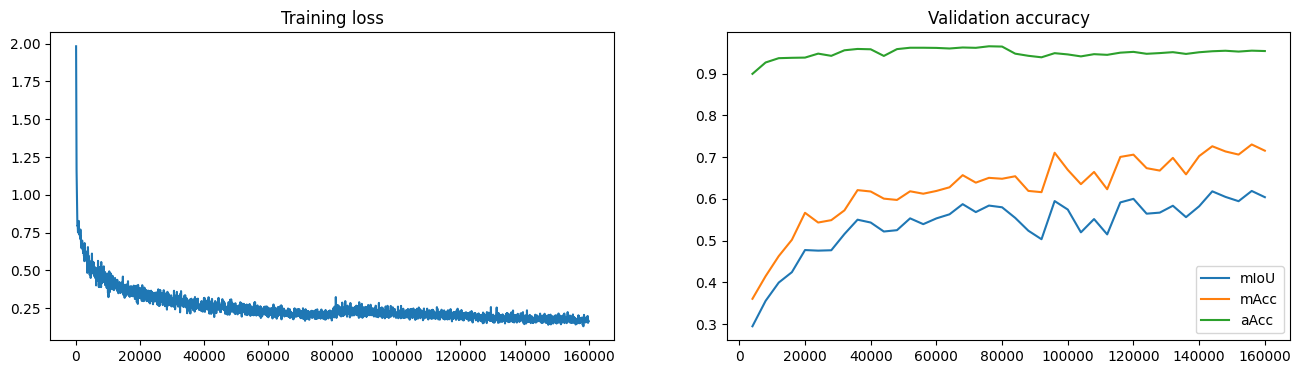

In [7]:
import json

train_iter, train_lr, train_decode_acc, train_loss = [], [], [], []
val_iter, val_miou, val_macc, val_aacc  = [], [], [], []

f = open('./segformer.b1.512x512.rarp50.80k/20230503_132722.log.json', 'r')
lines = f.readlines()
lines.pop(0)
for line in lines:
    js = json.loads(line)
    if js["mode"] == "train":
        train_iter.append(js["iter"])
        train_lr.append(js["lr"])
        train_decode_acc.append(js["decode.acc_seg"])
        train_loss.append(js["loss"])
    elif js["mode"] == "val":
        val_iter.append(js["iter"])
        val_miou.append(js["mIoU"])
        val_macc.append(js["mAcc"])
        val_aacc.append(js["aAcc"])

f = open('./segformer.b1.512x512.rarp50.160k/20230504_025001.log.json', 'r')
lines = f.readlines()
lines.pop(0)
for line in lines:
    js = json.loads(line)
    if js["mode"] == "train":
        train_iter.append(js["iter"])
        train_lr.append(js["lr"])
        train_decode_acc.append(js["decode.acc_seg"])
        train_loss.append(js["loss"])
    elif js["mode"] == "val":
        val_iter.append(js["iter"])
        val_miou.append(js["mIoU"])
        val_macc.append(js["mAcc"])
        val_aacc.append(js["aAcc"])

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(train_iter, train_loss)
plt.title("Training loss")

plt.subplot(122)
plt.plot(val_iter, val_miou)
plt.plot(val_iter, val_macc)
plt.plot(val_iter, val_aacc)
plt.title("Validation accuracy")
plt.legend(["mIoU", "mAcc", "aAcc"])


Use load_from_local loader


/home/deep/DL_project/Segformer_RARP50/mmseg/models/segmentors/base.py:268: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


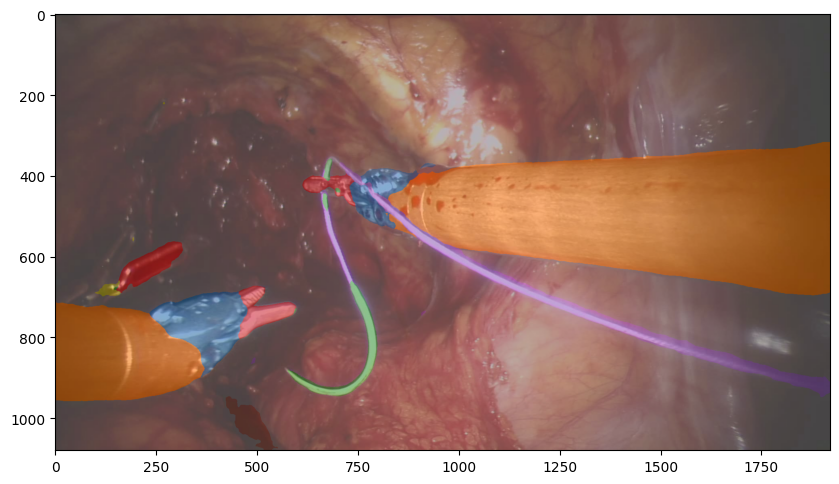

In [8]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

config_file = './segformer.b1.512x512.rarp50.160k/segformer.b1.512x512.rarp50.160k.py'
checkpoint_file = './segformer.b1.512x512.rarp50.160k/latest.pth'

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
img_dir = f_name_list[idx][0]
result = inference_segmentor(model, img_dir)
palette = np.array([mpl.colors.to_rgb(c) for c in colors])*255

show_result_pyplot(model, img_dir, result, palette.astype(int), (10,6))


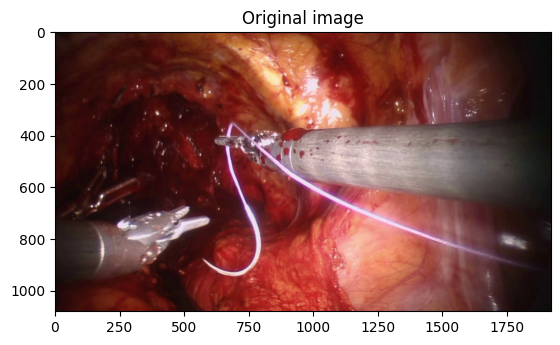

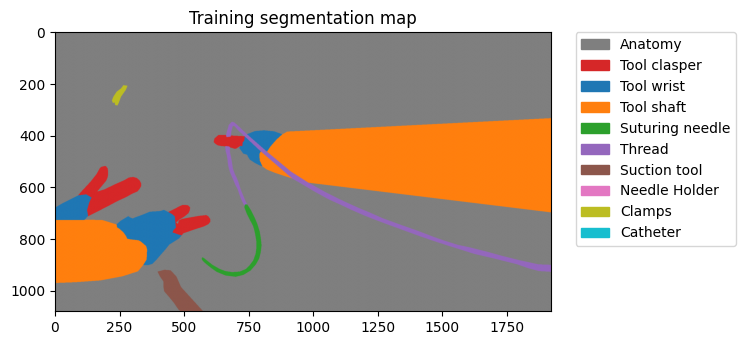

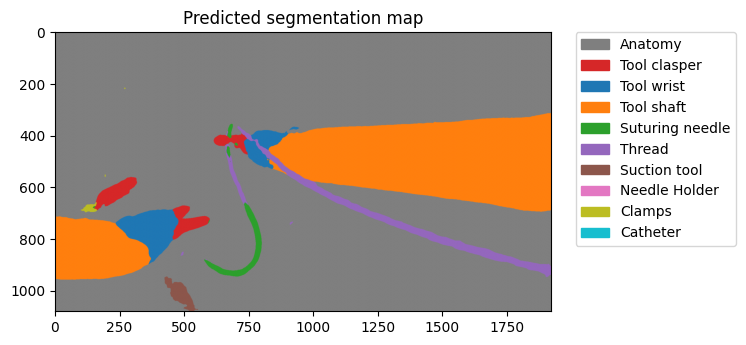

In [13]:
img_rgb = plt.imread(f_name_list[idx][0])
plt.imshow(img_rgb)
plt.title("Original image")
plt.show()

img_seg = Image.open(f_name_list[idx][1])
img_seg = np.array(img_seg.convert('RGB'), dtype=float)
for i in range(img_seg.shape[0]):
    for j in range(img_seg.shape[1]):
        img_seg[i,j,:] = palette_dict[img_seg[i,j,0]]

patches = [mpatches.Patch(color=colors[i], label=cls) for i, cls in enumerate(classes)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='medium')
plt.imshow(img_seg)
plt.title("Training segmentation map")
plt.show()

img_seg = np.zeros(img_rgb.shape, dtype=float)
for i in range(img_seg.shape[0]):
    for j in range(img_seg.shape[1]):
        img_seg[i,j,:] = palette_dict[result[0][i,j]]

patches = [mpatches.Patch(color=colors[i], label=cls) for i, cls in enumerate(classes)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='medium')
plt.imshow(img_seg)
plt.title("Predicted segmentation map")
plt.show()

## Train vs Val

In [ ]:
from mmseg.apis import init_segmentor, single_gpu_test, multi_gpu_test
from mmcv import Config
from mmseg.datasets import build_dataset, build_dataloader
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel

config_file = './segformer.b1.512x512.rarp50.160k/segformer.b1.512x512.rarp50.160k.py'
checkpoint_file = './segformer.b1.512x512.rarp50.160k/latest.pth'

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

cfg = Config.fromfile(config_file)
print(cfg.data.test.img_dir, cfg.data.test.ann_dir)


dataset = build_dataset(cfg.data.test)

data_loader = build_dataloader(
            dataset,
            cfg.data.samples_per_gpu,
            cfg.data.workers_per_gpu,
            # cfg.gpus will be ignored if distributed
            len(cfg.gpu_ids),
            dist=None,
            seed=None,
            drop_last=True)

model = MMDataParallel(model.cuda(cfg.gpu_ids[0]), device_ids=cfg.gpu_ids)

# single_gpu_test(model, data_loader, show=False, out_dir=None, efficient_test=False)
# multi_gpu_test(model, data_loader, tmpdir=None, gpu_collect=False, efficient_test=False)

2023-05-05 20:39:53,871 - mmseg - INFO - Loaded 132 images


Use load_from_local loader
video_test_1.zip/rgb video_test_1.zip/segmentation


## Read Val Results for file

In [15]:
import numpy as np

def read_log(filename, n):
    with open(filename, "r") as f:
        lines = f.readlines()

    # array 40 * #class
    class_iou = np.zeros((n, 10))
    class_acc = np.zeros((n, 10))
    global_stat = np.zeros((n, 3))

    cnt = 0
    for line in lines:
        cls = None
        if 'anatomy' in line:
            cls = 0
        elif 'tool_clasper' in line:
            cls = 1
        elif 'tool_wrist' in line:
            cls = 2
        elif 'tool_shaft' in line:
            cls = 3
        elif 'suturing_needle' in line:
            cls = 4
        elif 'thread' in line:
            cls = 5
        elif 'suction_tool' in line:
            cls = 6
        elif 'needle_holder' in line:
            cls = 7
        elif 'clamps' in line:
            cls = 8
        elif 'catheter' in line:
            cls = 9
        if cls != None:
            spt = line.split(' |')
            class_iou[cnt, cls] = float(spt[1])
            class_acc[cnt, cls] = float(spt[2])
            continue

        if 'global' in line:
            spt = line.split(' |')
            global_stat[cnt, 0] = float(spt[1])
            global_stat[cnt, 1] = float(spt[2])
            global_stat[cnt, 2] = float(spt[3])
            cnt = cnt + 1

        if cnt >= n:
            return (class_iou, class_acc, global_stat)
    

train_class_iou, train_class_acc, train_global = read_log("test_train_results.txt", 40)
val_class_iou, val_class_acc, val_global = read_log("test_val_results.txt", 40)

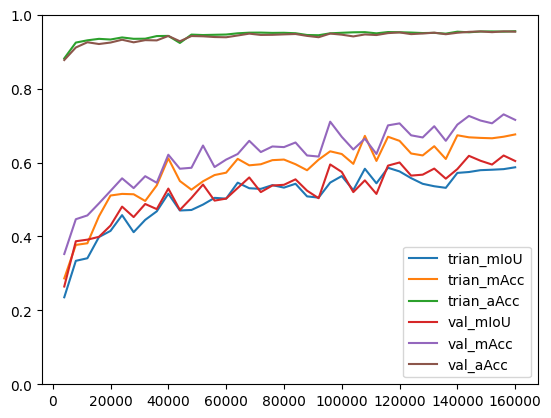

In [10]:
import matplotlib.pyplot as plt

plt.figure()
x_axis = np.arange(4000, 160001, 4000)
plt.plot(x_axis, train_global[:,0] / 100)
plt.plot(x_axis, train_global[:,1] / 100)
plt.plot(x_axis, train_global[:,2] / 100)
plt.plot(x_axis, val_global[:,0] / 100)
plt.plot(x_axis, val_global[:,1] / 100)
plt.plot(x_axis, val_global[:,2] / 100)
plt.legend(['trian_mIoU', 'trian_mAcc', 'trian_aAcc', 
            'val_mIoU', 'val_mAcc', 'val_aAcc'])
plt.ylim((0,1))
plt.show()

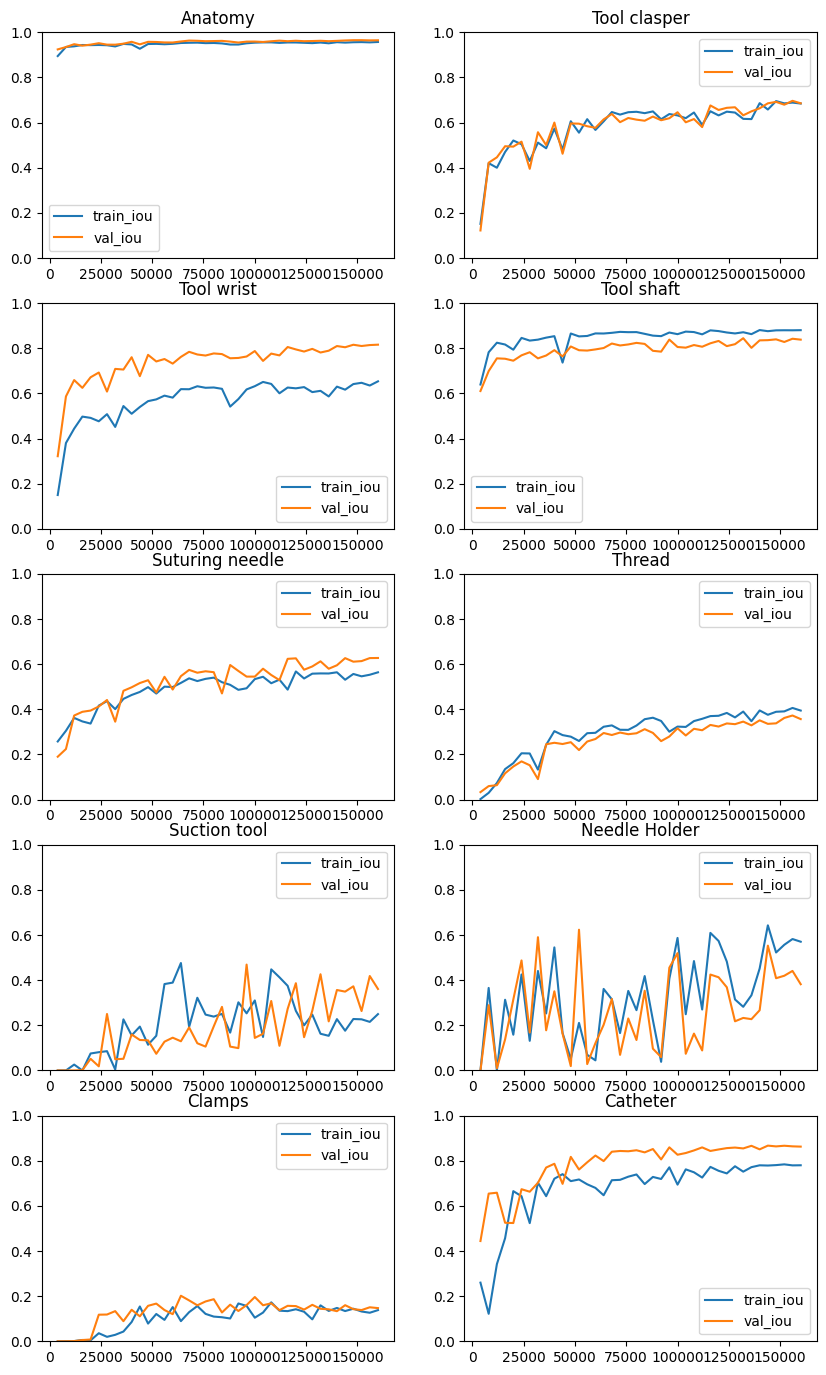

In [11]:
plt.figure(figsize=(10, 17))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(x_axis, train_class_iou[:,i] / 100)
    plt.plot(x_axis, val_class_iou[:,i] / 100)
    plt.ylim((0,1))
    plt.title(classes[i])
    plt.legend(["train_iou", "val_iou"])

plt.show()

## Class Weight Finetuning

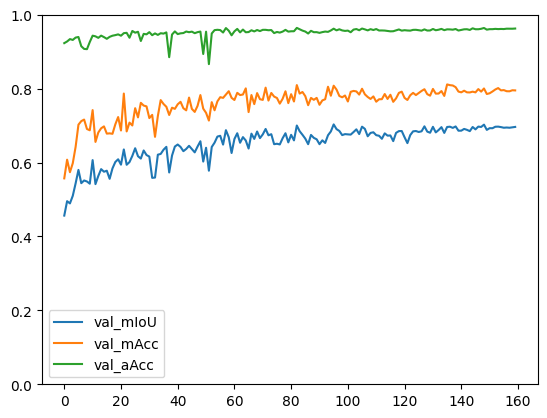

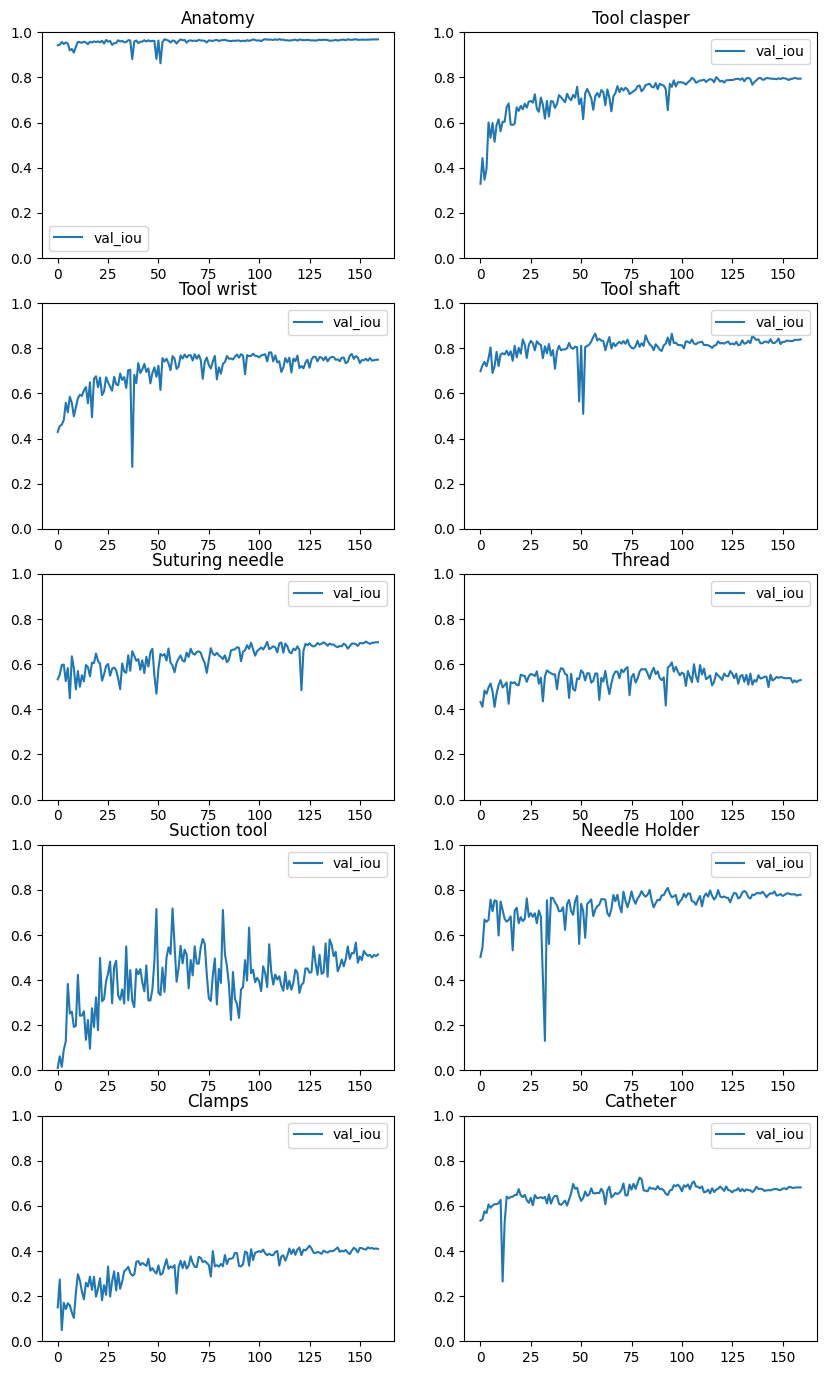

In [21]:
import matplotlib.pyplot as plt

val_class_iou, val_class_acc, val_global = read_log(
    "./segformer.b1.mit.80k.CW/20230508_212035.log", 160)


plt.figure()
plt.plot(val_global[:,0] / 100)
plt.plot(val_global[:,1] / 100)
plt.plot(val_global[:,2] / 100)
plt.legend(['val_mIoU', 'val_mAcc', 'val_aAcc'])
plt.ylim((0,1))
plt.show()

plt.figure(figsize=(10, 17))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(val_class_iou[:,i] / 100)
    plt.ylim((0,1))
    plt.title(classes[i])
    plt.legend(["val_iou"])

plt.show()

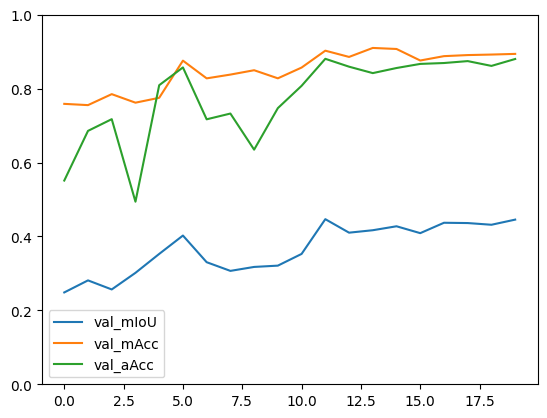

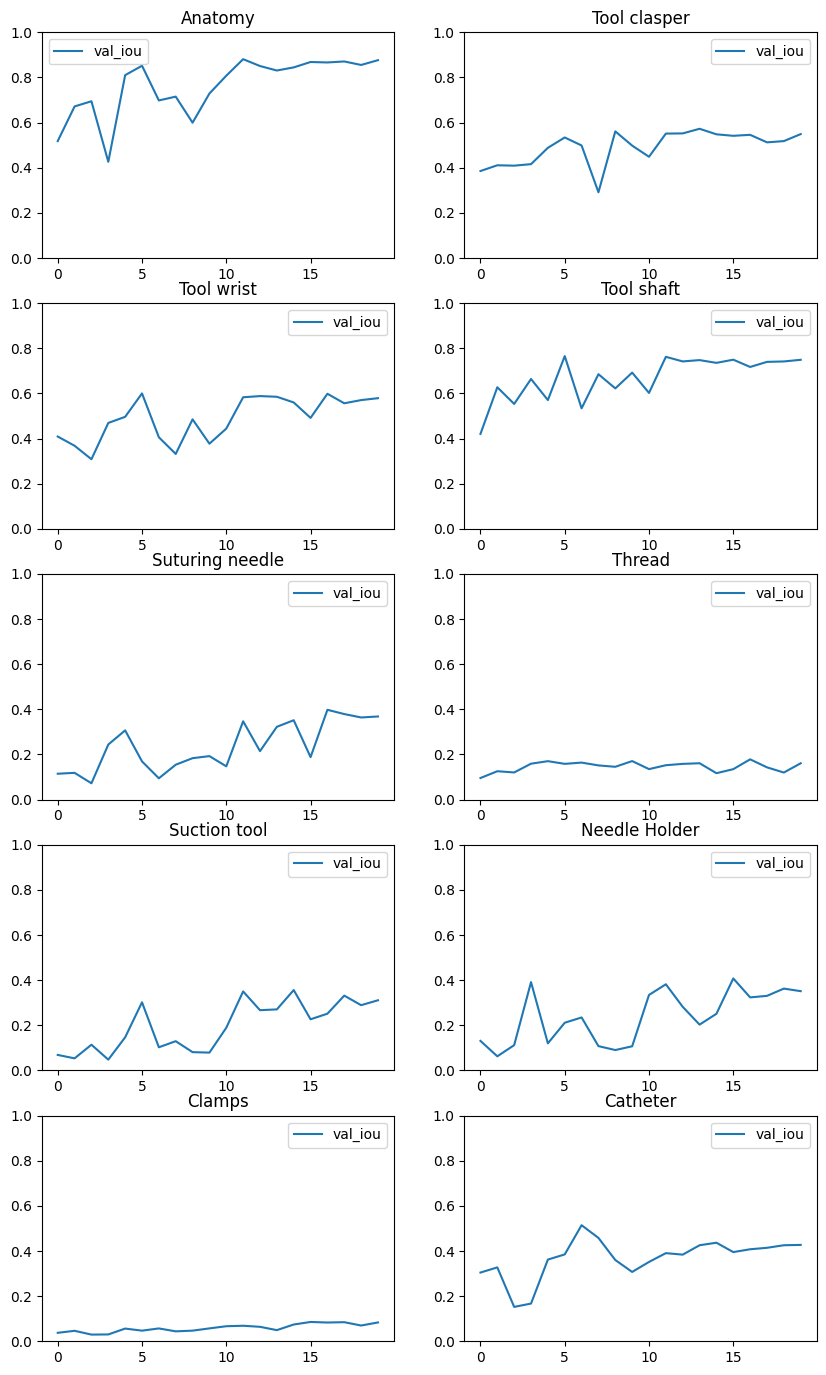

In [13]:
import matplotlib.pyplot as plt

val_class_iou, val_class_acc, val_global = read_log(
    "segformer.b1.endovis2018.40k/20230508_011006.log", 20)


plt.figure()
plt.plot(val_global[:,0] / 100)
plt.plot(val_global[:,1] / 100)
plt.plot(val_global[:,2] / 100)
plt.legend(['val_mIoU', 'val_mAcc', 'val_aAcc'])
plt.ylim((0,1))
plt.show()

plt.figure(figsize=(10, 17))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(val_class_iou[:,i] / 100)
    plt.ylim((0,1))
    plt.title(classes[i])
    plt.legend(["val_iou"])

plt.show()

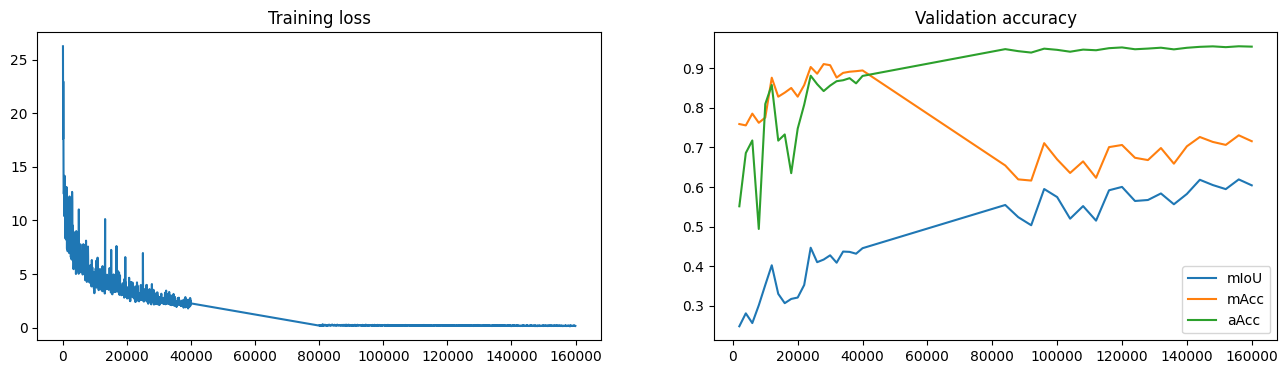

In [14]:
import json

train_iter, train_lr, train_decode_acc, train_loss = [], [], [], []
val_iter, val_miou, val_macc, val_aacc  = [], [], [], []

f = open('./segformer.b1.endovis2018.40k/20230508_011006.log.json', 'r')
lines = f.readlines()
lines.pop(0)
for line in lines:
    js = json.loads(line)
    if js["mode"] == "train":
        train_iter.append(js["iter"])
        train_lr.append(js["lr"])
        train_decode_acc.append(js["decode.acc_seg"])
        train_loss.append(js["loss"])
    elif js["mode"] == "val":
        val_iter.append(js["iter"])
        val_miou.append(js["mIoU"])
        val_macc.append(js["mAcc"])
        val_aacc.append(js["aAcc"])

f = open('./segformer.b1.512x512.rarp50.160k/20230504_025001.log.json', 'r')
lines = f.readlines()
lines.pop(0)
for line in lines:
    js = json.loads(line)
    if js["mode"] == "train":
        train_iter.append(js["iter"])
        train_lr.append(js["lr"])
        train_decode_acc.append(js["decode.acc_seg"])
        train_loss.append(js["loss"])
    elif js["mode"] == "val":
        val_iter.append(js["iter"])
        val_miou.append(js["mIoU"])
        val_macc.append(js["mAcc"])
        val_aacc.append(js["aAcc"])

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(train_iter, train_loss)
plt.title("Training loss")

plt.subplot(122)
plt.plot(val_iter, val_miou)
plt.plot(val_iter, val_macc)
plt.plot(val_iter, val_aacc)
plt.title("Validation accuracy")
plt.legend(["mIoU", "mAcc", "aAcc"])


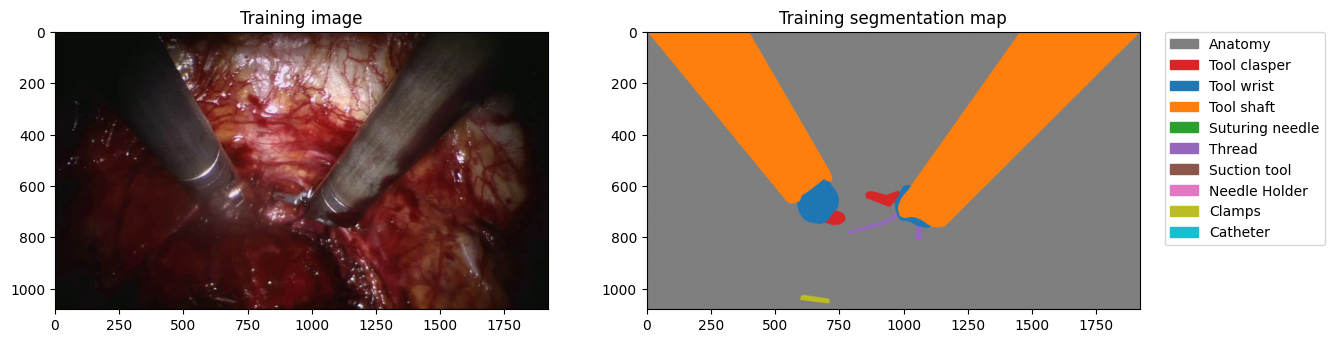

In [30]:
root_dir = '/media/deep/Transcend/sar-rarp-dataset/traindata/video_1.zip/'
seg_dir = 'segmentation/'
rgb_dir = 'rgb/'

f_name_list = []
for seg_name in glob.glob(root_dir + seg_dir + '*.png'):
    rgb_name = glob.glob(root_dir + rgb_dir + seg_name.split('/')[-1])[0]
    f_name_list.append([rgb_name, seg_name])

colors = ['tab:gray', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
palette_dict = {i: mpl.colors.to_rgb(c) for i, c in enumerate(colors)}
classes = ("Anatomy", "Tool clasper", "Tool wrist", "Tool shaft", "Suturing needle", "Thread", "Suction tool", "Needle Holder", "Clamps", "Catheter")

idx = 1
plt.figure(figsize=(14,20))
plt.subplot(121)
img_rgb = plt.imread(f_name_list[idx][0])
plt.imshow(img_rgb)
plt.title("Training image")

plt.subplot(122)
img_seg = Image.open(f_name_list[idx][1])
img_seg = np.array(img_seg.convert('RGB'), dtype=float)
for i in range(img_seg.shape[0]):
    for j in range(img_seg.shape[1]):
        img_seg[i,j,:] = palette_dict[img_seg[i,j,0]]

patches = [mpatches.Patch(color=colors[i], label=cls) for i, cls in enumerate(classes)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='medium')
plt.imshow(img_seg)
plt.title("Training segmentation map")
plt.show()

Use load_from_local loader


/home/deep/DL_project/Segformer_RARP50/mmseg/models/segmentors/base.py:268: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


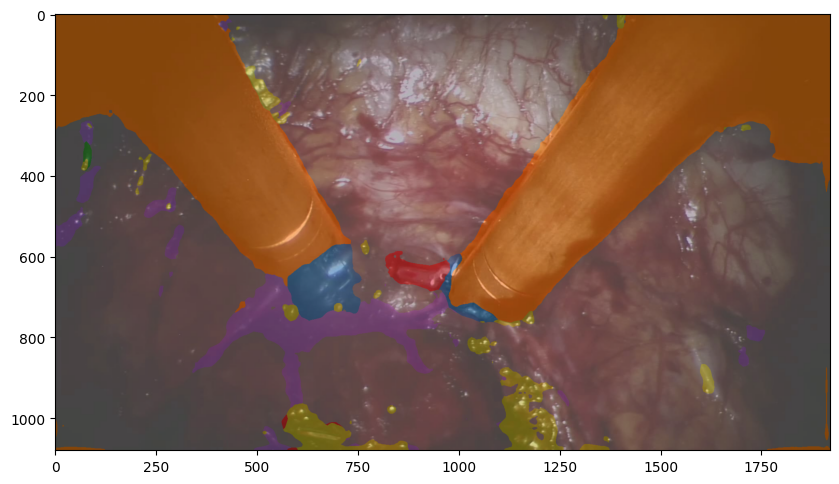

In [31]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

config_file = './segformer.b1.endovis2018.40k/segformer.b1.endovis2018.40k.py'
checkpoint_file = './segformer.b1.endovis2018.40k/latest.pth'

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
img_dir = f_name_list[idx][0]
result = inference_segmentor(model, img_dir)
palette = np.array([mpl.colors.to_rgb(c) for c in colors])*255

show_result_pyplot(model, img_dir, result, palette.astype(int), (10,6))

Use load_from_local loader


/home/deep/DL_project/Segformer_RARP50/mmseg/models/segmentors/base.py:268: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


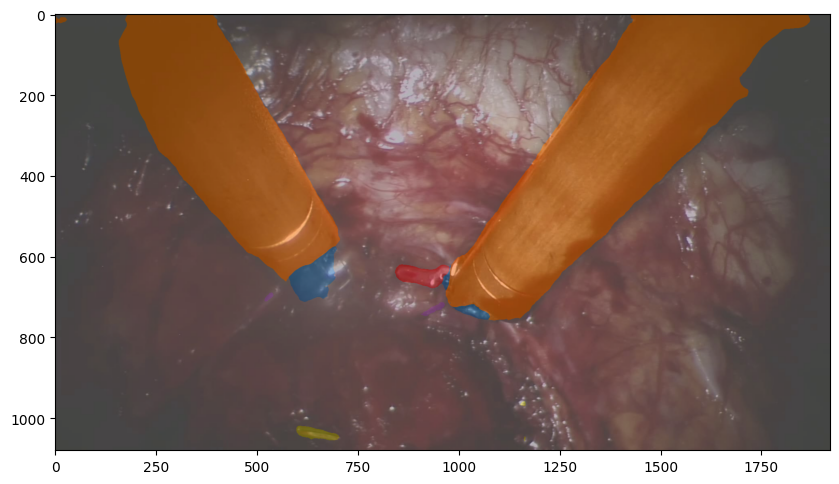

In [32]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

config_file = './segformer.b1.endovis2018.80k.finetune/segformer.b1.endovis2018.80k.finetune.py'
checkpoint_file = './segformer.b1.endovis2018.80k.finetune/latest.pth'

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')
img_dir = f_name_list[idx][0]
result = inference_segmentor(model, img_dir)
palette = np.array([mpl.colors.to_rgb(c) for c in colors])*255

show_result_pyplot(model, img_dir, result, palette.astype(int), (10,6))

## Endovis 2018 pretrained 40k small val

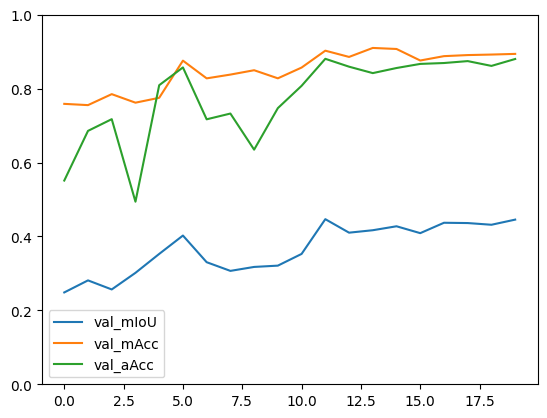

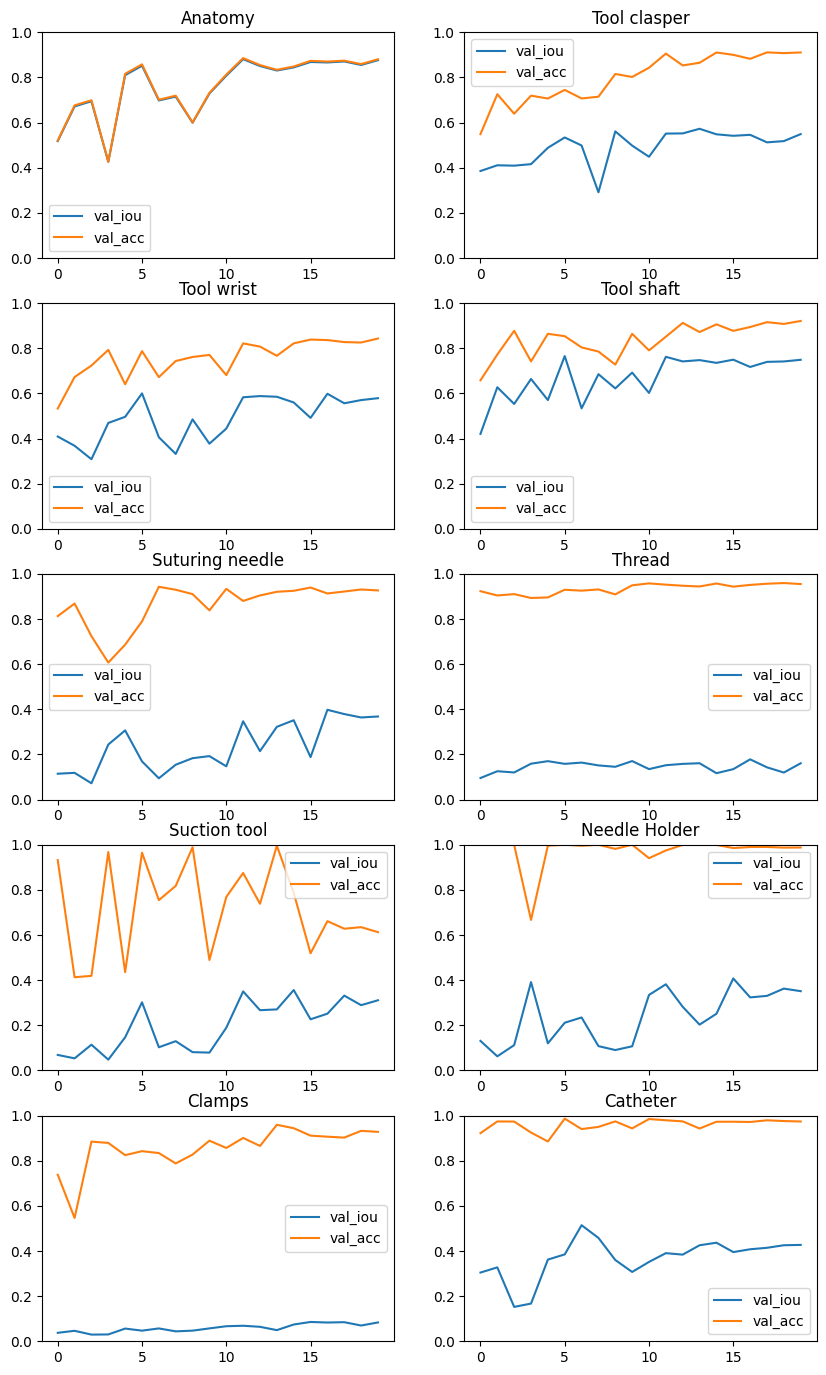

In [24]:
import matplotlib.pyplot as plt

val_class_iou, val_class_acc, val_global = read_log(
    "./segformer.b1.endovis2018.40k/20230508_011006.log", 20)


plt.figure()
plt.plot(val_global[:,0] / 100)
plt.plot(val_global[:,1] / 100)
plt.plot(val_global[:,2] / 100)
plt.legend(['val_mIoU', 'val_mAcc', 'val_aAcc'])
plt.ylim((0,1))
plt.show()

plt.figure(figsize=(10, 17))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(val_class_iou[:,i] / 100)
    plt.plot(val_class_acc[:,i] / 100)
    plt.ylim((0,1))
    plt.title(classes[i])
    plt.legend(["val_iou", "val_acc"])

plt.show()

## Endovis 2018 pretrained 80k small val

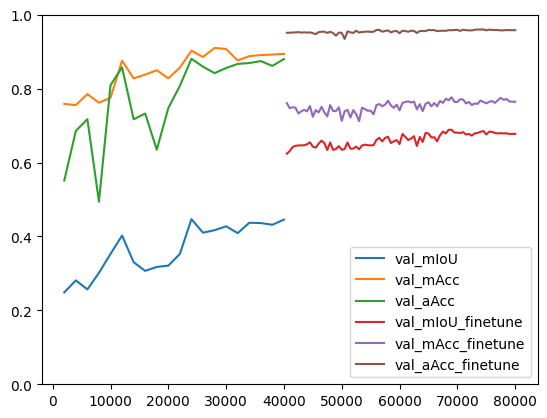

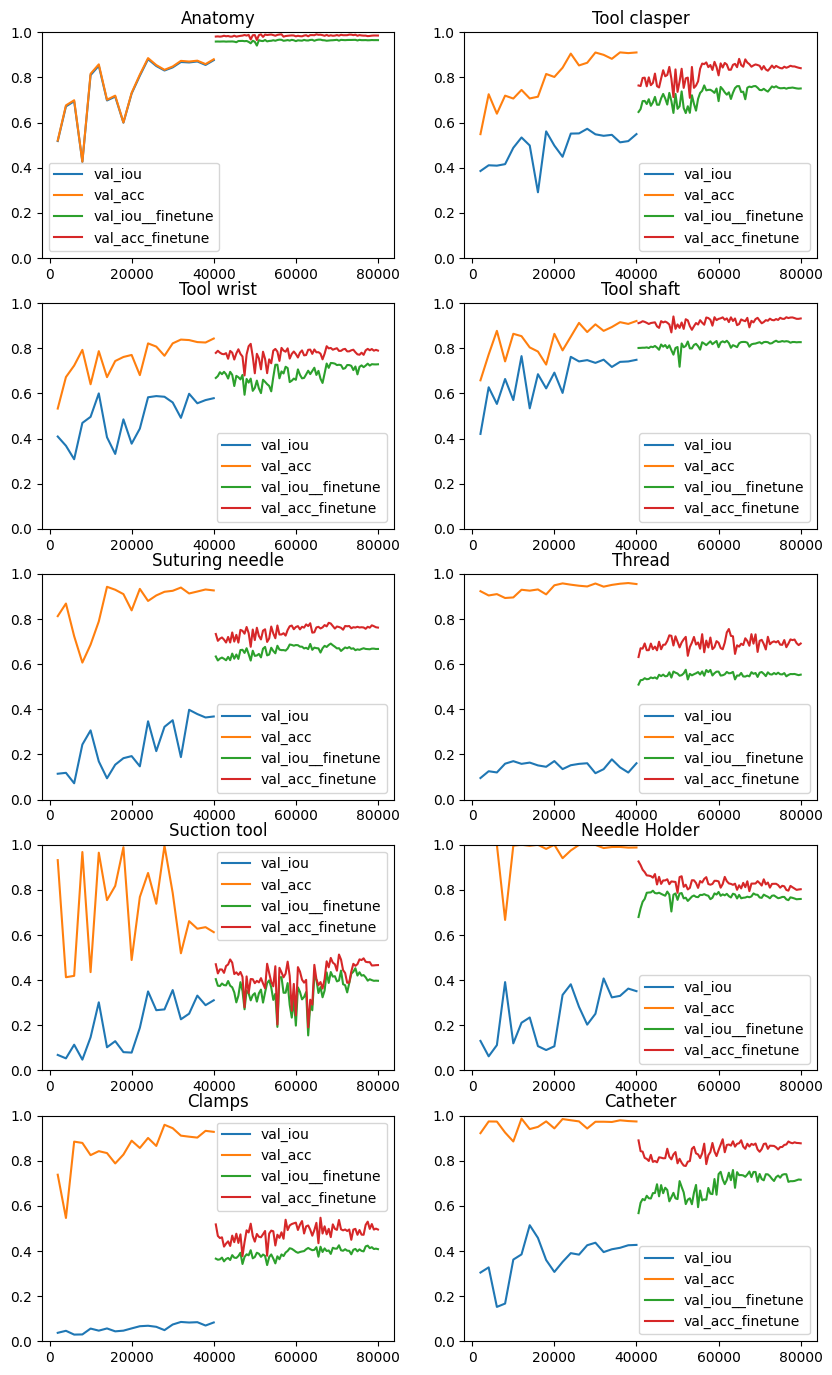

In [14]:
import matplotlib.pyplot as plt

val_class_iou, val_class_acc, val_global = read_log(
    "./segformer.b1.endovis2018.40k/20230508_011006.log", 20)

val_class_iou_2, val_class_acc_2, val_global_2 = read_log(
    "./segformer.b1.endovis2018.80k.finetune/20230508_081953.log", 80)

x1 = np.arange(2000, 40001, 2000)
x2 = np.arange(40500, 80001, 500)

plt.figure()
plt.plot(x1, val_global[:,0] / 100)
plt.plot(x1, val_global[:,1] / 100)
plt.plot(x1, val_global[:,2] / 100)
plt.plot(x2, val_global_2[:,0] / 100)
plt.plot(x2, val_global_2[:,1] / 100)
plt.plot(x2, val_global_2[:,2] / 100)
plt.legend(['val_mIoU', 'val_mAcc', 'val_aAcc', 'val_mIoU_finetune', 'val_mAcc_finetune', 'val_aAcc_finetune'])
plt.ylim((0,1))
plt.show()

plt.figure(figsize=(10, 17))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(x1, val_class_iou[:,i] / 100)
    plt.plot(x1, val_class_acc[:,i] / 100)
    plt.plot(x2, val_class_iou_2[:,i] / 100)
    plt.plot(x2, val_class_acc_2[:,i] / 100)
    plt.ylim((0,1))
    plt.title(classes[i])
    plt.legend(["val_iou", "val_acc", "val_iou__finetune", "val_acc_finetune"])

plt.show()

## mit trained class weights

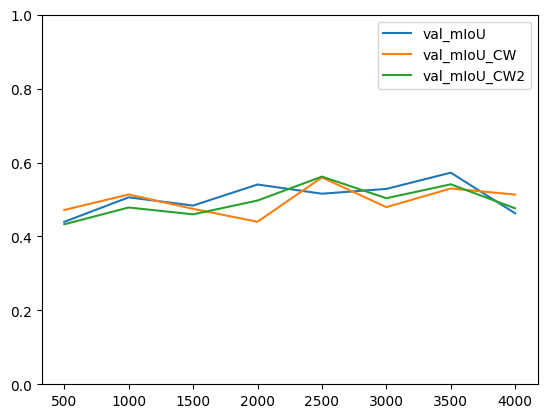

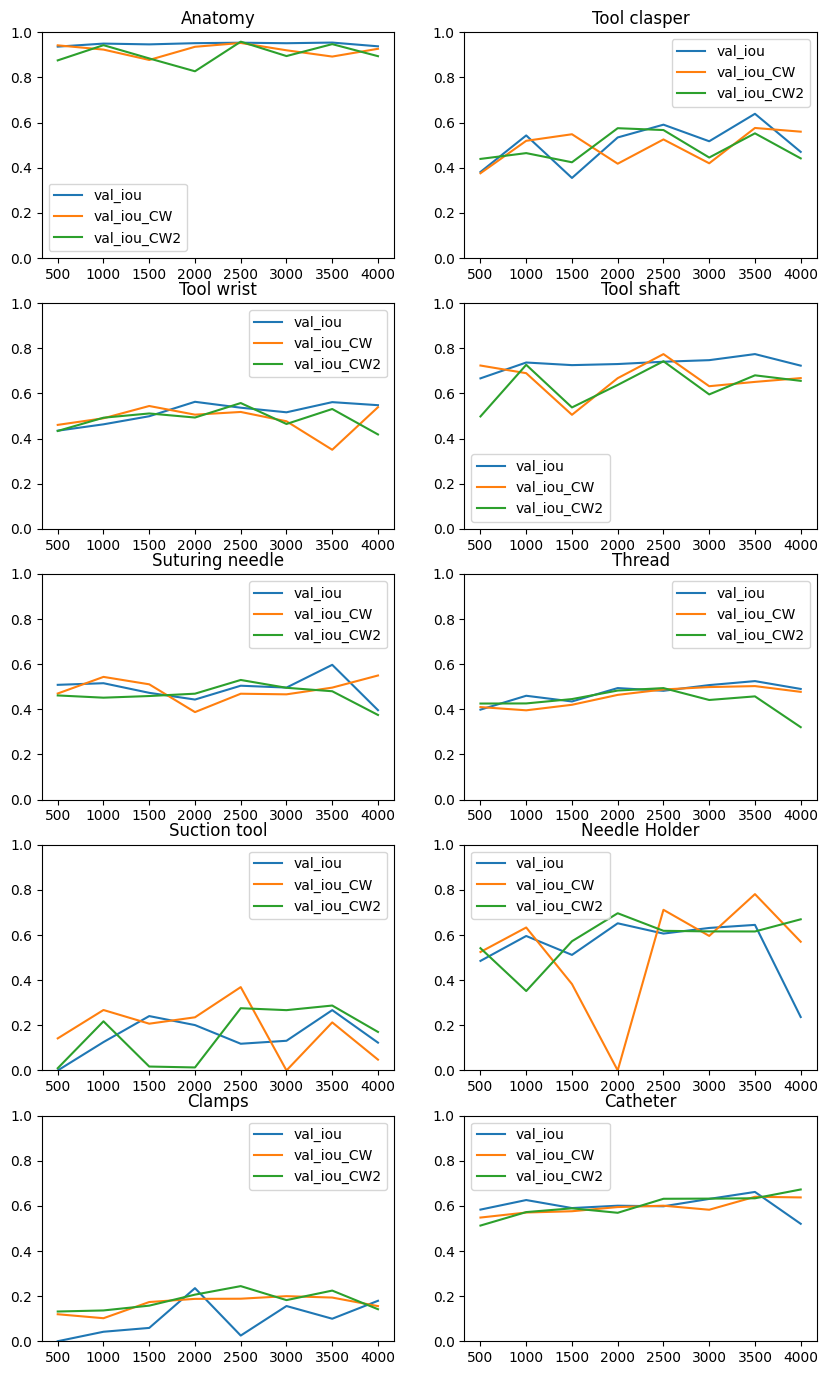

In [23]:
import matplotlib.pyplot as plt

classes = ("Anatomy", "Tool clasper", "Tool wrist", "Tool shaft", "Suturing needle", "Thread", "Suction tool", "Needle Holder", "Clamps", "Catheter")

val_class_iou, val_class_acc, val_global = read_log("./segformer.b1.mit.80k/20230508_165417.log", 8)
val_class_iou_cw, val_class_acc_cw, val_global_cw = read_log("./segformer.b1.mit.80k.CW/20230508_161001.log", 8)
val_class_iou_cw2, val_class_acc_cw2, val_global_cw2 = read_log("./segformer.b1.mit.80k.CW2/20230508_174322.log", 8)


x1 = np.arange(500, 4001, 500)

plt.figure()
plt.plot(x1, val_global[:,0] / 100)
plt.plot(x1, val_global_cw[:,0] / 100)
plt.plot(x1, val_global_cw2[:,0] / 100)
plt.legend(['val_mIoU', 'val_mIoU_CW', 'val_mIoU_CW2'])
plt.ylim((0,1))
plt.show()

plt.figure(figsize=(10, 17))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(x1, val_class_iou[:,i] / 100)
    plt.plot(x1, val_class_iou_cw[:,i] / 100)
    plt.plot(x1, val_class_iou_cw2[:,i] / 100)
    plt.ylim((0,1))
    plt.title(classes[i])
    plt.legend(["val_iou", "val_iou_CW", "val_iou_CW2"])

plt.show()